# Imports

In [1]:
%%capture
!pip install deepface

In [6]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from deepface import DeepFace
from tqdm import tqdm
from skimage import data
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.datasets import cifar10

# 2D Planar Transformations

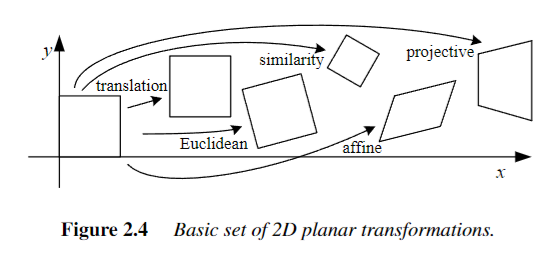

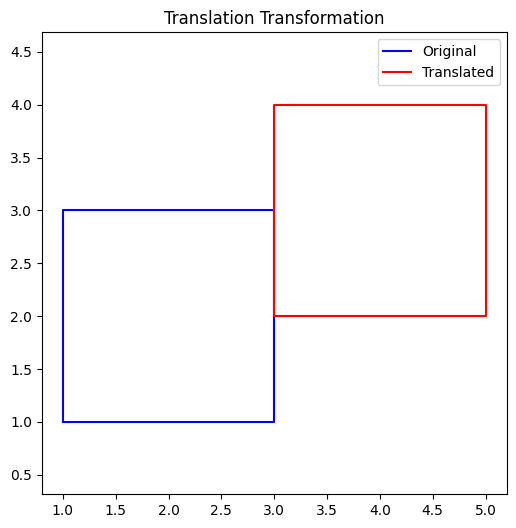

In [7]:
# Translation: Moves every point of an object by the same distance in a given direction.
def plot_translation():
    # Original shape: a square
    square = np.array([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]])

    # Translation matrix (tx = 2, ty = 1)
    tx, ty = 2, 1
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])

    # Homogeneous coordinates
    square_homogeneous = np.c_[square, np.ones((square.shape[0], 1))]

    # Apply translation
    translated_square = (T @ square_homogeneous.T).T[:, :2]

    # Plot original and translated squares
    plt.figure(figsize=(6, 6))
    plt.plot(square[:, 0], square[:, 1], 'b-', label='Original')
    plt.plot(translated_square[:, 0], translated_square[:, 1], 'r-', label='Translated')
    plt.title('Translation Transformation')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_translation()

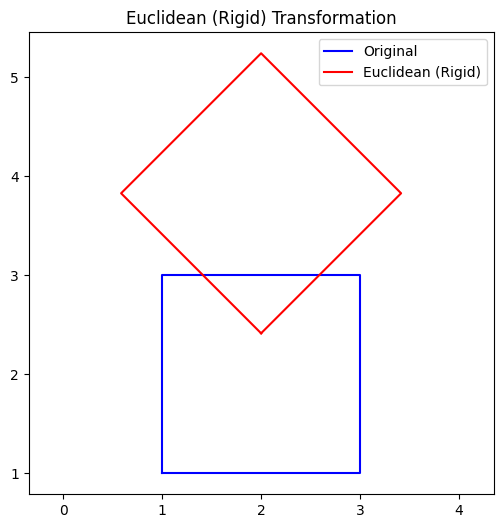

In [8]:
# Euclidean (Rigid): Combines rotation and translation, preserving distances and angles.
def plot_euclidean():
    # Original shape: a square
    square = np.array([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]])

    # Rotation matrix for 45 degrees
    theta = np.radians(45)
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])

    # Translation matrix (tx = 2, ty = 1)
    tx, ty = 2, 1
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])

    # Combined Euclidean transformation (Translation + Rotation)
    Euclidean = T @ R

    # Homogeneous coordinates
    square_homogeneous = np.c_[square, np.ones((square.shape[0], 1))]

    # Apply Euclidean transformation
    transformed_square = (Euclidean @ square_homogeneous.T).T[:, :2]

    # Plot original and transformed squares
    plt.figure(figsize=(6, 6))
    plt.plot(square[:, 0], square[:, 1], 'b-', label='Original')
    plt.plot(transformed_square[:, 0], transformed_square[:, 1], 'r-', label='Euclidean (Rigid)')
    plt.title('Euclidean (Rigid) Transformation')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_euclidean()

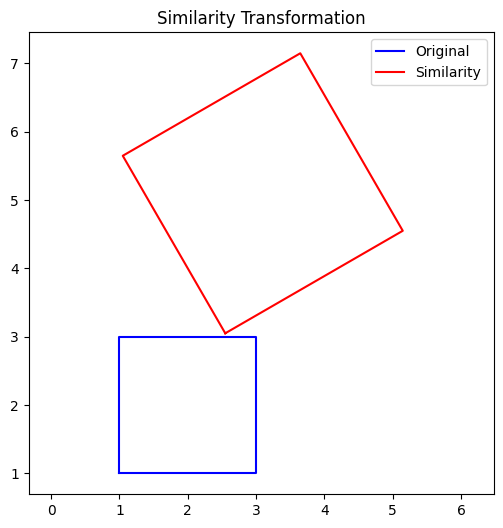

In [9]:
# Similarity: Combines Euclidean transformations with scaling, preserving the shape.
def plot_similarity():
    # Original shape: a square
    square = np.array([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]])

    # Rotation matrix for 30 degrees
    theta = np.radians(30)
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])

    # Scaling factor
    s = 1.5
    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]])

    # Translation matrix (tx = 2, ty = 1)
    tx, ty = 2, 1
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])

    # Combined Similarity transformation (Translation + Rotation + Scaling)
    Similarity = T @ R @ S

    # Homogeneous coordinates
    square_homogeneous = np.c_[square, np.ones((square.shape[0], 1))]

    # Apply Similarity transformation
    transformed_square = (Similarity @ square_homogeneous.T).T[:, :2]

    # Plot original and transformed squares
    plt.figure(figsize=(6, 6))
    plt.plot(square[:, 0], square[:, 1], 'b-', label='Original')
    plt.plot(transformed_square[:, 0], transformed_square[:, 1], 'r-', label='Similarity')
    plt.title('Similarity Transformation')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_similarity()

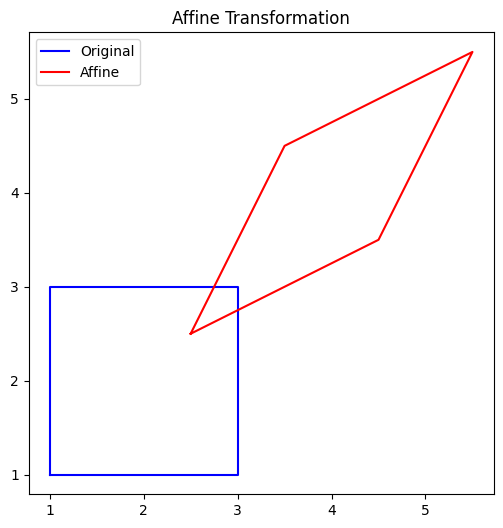

In [10]:
# Affine: A general linear transformation that includes scaling, rotation, translation, and shearing,
# preserving parallelism but not necessarily distances or angles.
def plot_affine():
    # Original shape: a square
    square = np.array([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]])

    # Affine transformation matrix (rotation, scaling, shearing, translation)
    A = np.array([[1, 0.5, 1],   # Shear + Scale + Translate
                  [0.5, 1, 1],
                  [0, 0, 1]])

    # Homogeneous coordinates
    square_homogeneous = np.c_[square, np.ones((square.shape[0], 1))]

    # Apply Affine transformation
    transformed_square = (A @ square_homogeneous.T).T[:, :2]

    # Plot original and transformed squares
    plt.figure(figsize=(6, 6))
    plt.plot(square[:, 0], square[:, 1], 'b-', label='Original')
    plt.plot(transformed_square[:, 0], transformed_square[:, 1], 'r-', label='Affine')
    plt.title('Affine Transformation')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_affine()

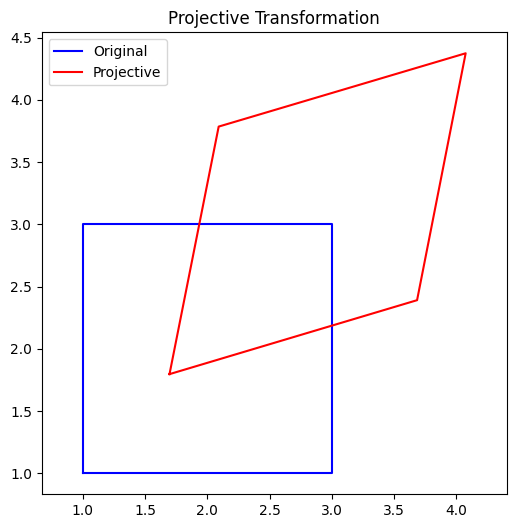

In [11]:
# Projective: A transformation that applies perspective distortion, which can map a square to any
# quadrilateral, preserving straight lines but not parallelism.
def plot_projective():
    # Original shape: a square
    square = np.array([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]])

    # Projective transformation matrix
    P = np.array([[1, 0.2, 0.5],
                  [0.3, 1, 0.5],
                  [0.001, 0.001, 1]])  # Perspective effect

    # Homogeneous coordinates
    square_homogeneous = np.c_[square, np.ones((square.shape[0], 1))]

    # Apply Projective transformation
    transformed_square = (P @ square_homogeneous.T).T
    transformed_square /= transformed_square[:, 2].reshape(-1, 1)  # Normalize by the third coordinate

    # Plot original and transformed squares
    plt.figure(figsize=(6, 6))
    plt.plot(square[:, 0], square[:, 1], 'b-', label='Original')
    plt.plot(transformed_square[:, 0], transformed_square[:, 1], 'r-', label='Projective')
    plt.title('Projective Transformation')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_projective()

# Lens Distortions

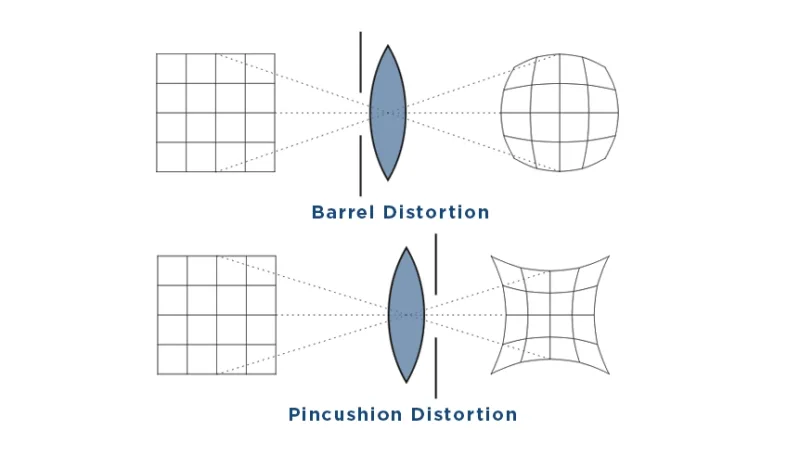

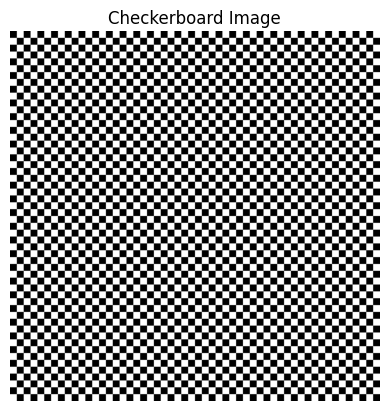

In [12]:
# Function to generate a checkerboard pattern
def generate_checkerboard(size=8, num_tiles=8):
    # Create an alternating black and white pattern
    row_pattern = np.array([0, 1] * num_tiles)
    checkerboard = np.row_stack([row_pattern, row_pattern[::-1]] * num_tiles)

    # Scale up the checkerboard pattern to desired size
    checkerboard = np.kron(checkerboard, np.ones((size, size)))

    # Convert to RGB format for OpenCV/Matplotlib (checkerboard is initially black & white)
    checkerboard_rgb = np.stack([checkerboard] * 3, axis=-1) * 255  # Convert to 3-channel RGB and scale to 255
    return checkerboard_rgb.astype(np.uint8)

# Generate the checkerboard image
checkerboard_image = generate_checkerboard(size=50, num_tiles=27)

# Display the checkerboard image
plt.imshow(checkerboard_image)
plt.title('Checkerboard Image')
plt.axis('off')
plt.show()

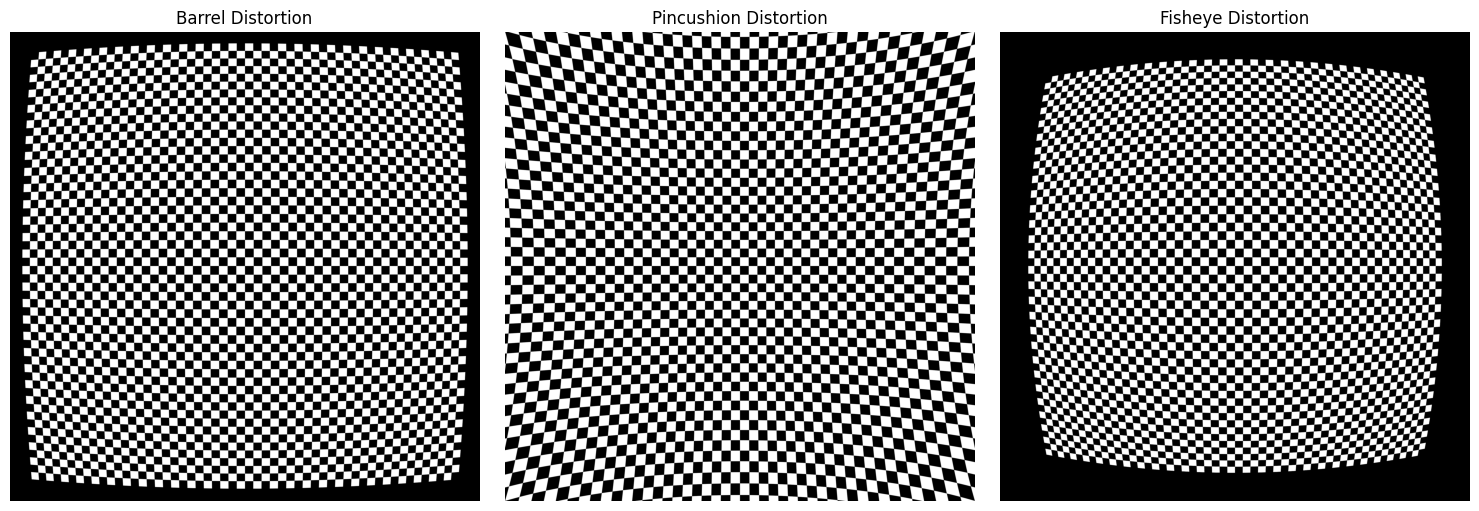

In [13]:
def distort_image(image, k1=0, k2=0, k3=0):
    h, w = image.shape[:2]
    fx, fy = 0.9 * w, 0.9 * h  # Focal length
    cx, cy = w / 2, h / 2  # Center of the image

    # Camera matrix
    camera_matrix = np.array([[fx, 0, cx],
                              [0, fy, cy],
                              [0, 0, 1]], dtype=np.float32)

    # Distortion coefficients
    dist_coeffs = np.array([k1, k2, k3, 0, 0], dtype=np.float32)

    # Apply distortion
    distorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)

    return distorted_image

# Apply Barrel Distortion
barrel_image = distort_image(checkerboard_image, k1=0.2)

# Apply Pincushion Distortion
pincushion_image = distort_image(checkerboard_image, k1=-0.3)

# Apply Fisheye Distortion
fisheye_image = distort_image(checkerboard_image, k1=0.5, k2=0.3)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(barrel_image)
axs[0].set_title('Barrel Distortion')
axs[0].axis('off')

axs[1].imshow(pincushion_image)
axs[1].set_title('Pincushion Distortion')
axs[1].axis('off')

axs[2].imshow(fisheye_image)
axs[2].set_title('Fisheye Distortion')
axs[2].axis('off')

plt.tight_layout()
plt.show()


1.   **Barrel Distortion:** Causes the image to appear bulged outwards like a barrel. This happens when magnification decreases with distance from the center of the image.
2.   **Pincushion Distortion:** Opposite of barrel distortion, this causes the image to appear pinched inward toward the center, with magnification increasing with distance from the center.
3. **Fisheye Distortion:** An extreme type of barrel distortion that creates a curved and hemispherical appearance, often used deliberately for artistic effect.


# Instance Detection (SIFT)

- **Keypoints:** These are the distinctive points in an image, such as edges, corners, or blobs (texture-rich regions) that can be reliably detected even when the image is transformed.

- **Descriptors:** These are feature vectors that describe the neighborhood around each keypoint. These descriptors are used for tasks like image matching and object recognition.

**How SIFT Works:**

**Step 1: Scale-space Extrema Detection (Finding the Keypoints)**

**Goal:** Identify potential keypoints that are invariant to scale. This means they should be detectable regardless of whether the object appears larger or smaller in the image.

**How It Starts:**

- SIFT begins by constructing a scale-space representation of the image. It does this by progressively smoothing the image with a Gaussian filter and subtracting consecutive smoothed versions, generating a series of images known as Difference of Gaussians (DoG). This process helps identify points of interest at different scales.

- The image is repeatedly blurred, and at each level of blurring (or "octave"), the algorithm searches for points where the image has local extrema (maxima or minima). This means that a pixel is compared to its neighbors (in the current scale, as well as neighboring scales) to see if it stands out in terms of contrast.

- **Why This Step Is Important:** Scale-space extrema points indicate areas in the image that are consistent across different scales. These are candidates for keypoints. SIFT chooses keypoints that are local maxima or minima in the DoG images, meaning they are distinctive areas in the image that are not easily confused with other regions.

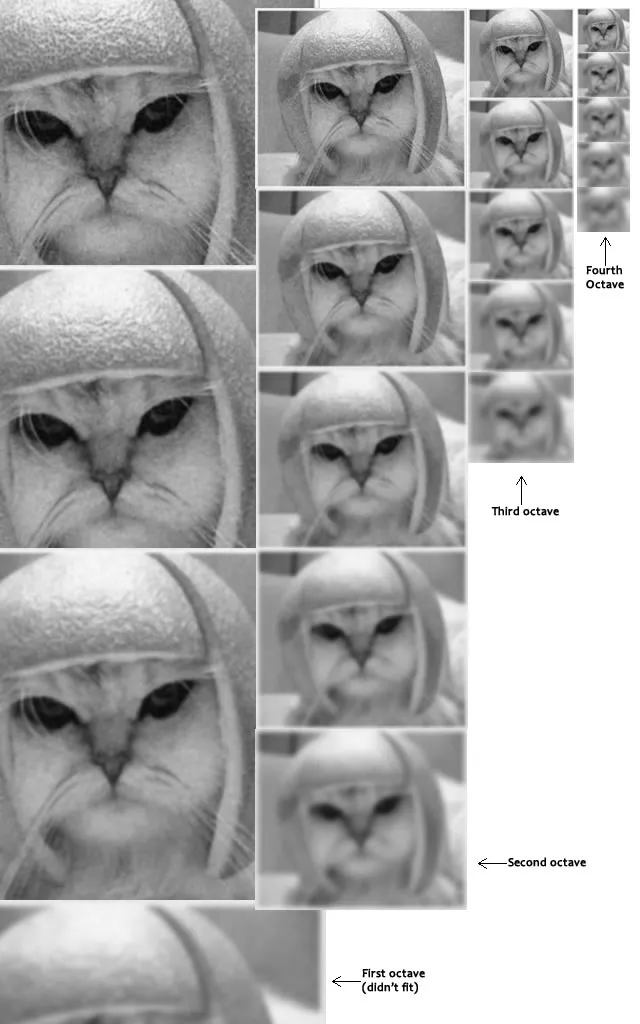

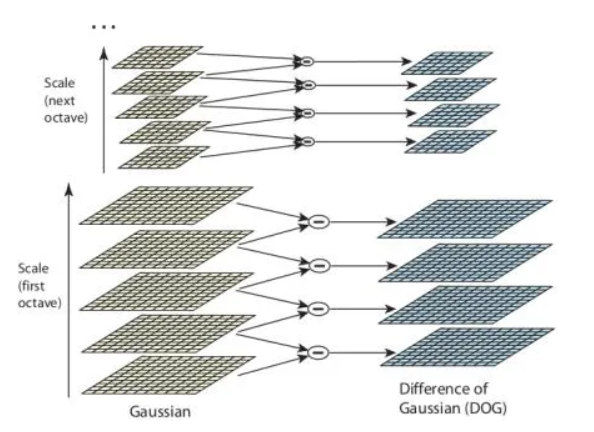

**Step 2: Keypoint Localization (Refining the Keypoints)**

**Goal:** Precisely locate keypoints and reject unstable ones.

**How It Works:**

- After identifying the candidate keypoints from the DoG images, SIFT refines their location by fitting a 3D quadratic function to the local pixel intensities. This helps to pinpoint the exact sub-pixel location of the keypoints.

- Targeting Strong Keypoints: SIFT discards keypoints that have low contrast (weak edges) or that lie along edges (unstable keypoints) because such keypoints are not distinctive and can lead to false matches. The stability of the keypoints is determined by analyzing the curvature of the DoG images at the keypoint location.

- **What It Targets:** Strong, well-defined keypoints that represent distinctive regions in the image. These regions are typically corners, blobs, or junctions in the image that remain consistent under transformations.

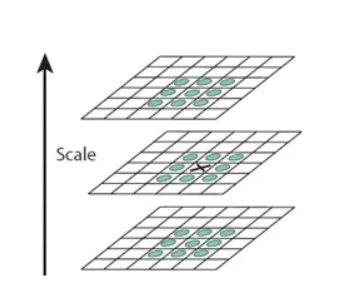

**Step 3: Orientation Assignment (Making Keypoints Rotation Invariant)**

**Goal:** Assign an orientation to each keypoint to make it invariant to image rotation.

**How It Works:**

- For each keypoint, SIFT computes the local gradient direction and magnitude in its neighborhood. A gradient is essentially a change in intensity from one pixel to the next, and the direction of this change is the gradient orientation.

- An orientation histogram is created by accumulating the gradient directions in the keypoint’s local neighborhood. The most prominent peak in this histogram is chosen as the dominant orientation for the keypoint. This orientation is used to rotate the keypoint and its descriptor so that the keypoint becomes rotation invariant.

- **What It Targets:** The dominant gradient direction at the keypoint's location. By aligning the keypoint to this dominant direction, SIFT ensures that the keypoint will be recognized correctly even if the image is rotated.

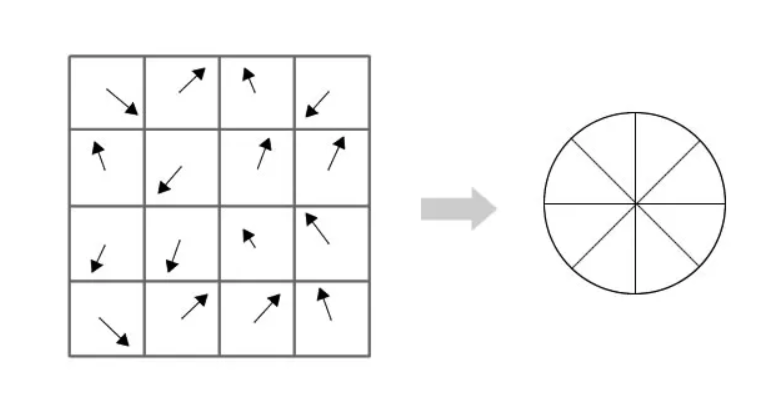

**Step 4: Keypoint Descriptor Creation (Generating Descriptors)**

**Goal:** Describe the area around each keypoint in a way that is distinctive yet invariant to small changes in lighting, orientation, and scale.

**How It Works:**

- For each keypoint, a 16x16 window around the keypoint is divided into 4x4 subregions. In each of these subregions, the gradient magnitudes and orientations are calculated, and an orientation histogram with 8 bins is created. This gives a detailed representation of how the image gradients are distributed around the keypoint.

- The descriptors are built by concatenating these histograms into a 128-dimensional vector (4x4 subregions × 8 orientations = 128). This descriptor vector provides a highly detailed summary of the local appearance around the keypoint.

- **What It Targets:** The gradients and orientations of pixel intensities around the keypoint. These provide robust information that can be used to match keypoints even if the image is transformed.

**Step 5: Keypoint Matching (Not in this Lab)**

**Goal:** Match keypoints across different images to recognize objects or instances.

**How It Works:**

- Once the descriptors are calculated for all keypoints, they are stored in a database. When matching across images, SIFT compares the descriptors of keypoints between two images and uses a nearest-neighbor search to find the best matches.

- This matching process is what allows SIFT to recognize objects in new images or find instances of the same object across different scenes.

To know more, [clicky-clicky](https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40)

In [14]:
eagle_image = data.eagle()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(eagle_image, None)

# Plotting the keypoints on the original color image
img_keypoints = cv2.drawKeypoints(eagle_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(img_keypoints)
plt.title('SIFT Keypoints on Original Color Eagle Image')
plt.xticks([])
plt.yticks([])
plt.show()

ModuleNotFoundError: The requested file is part of the scikit-image distribution, but requires the installation of an optional dependency, pooch. To install pooch, use your preferred python package manager. Follow installation instruction found at https://scikit-image.org/docs/stable/user_guide/install.html

# Image classification

**Feature-based classification**

This is a good visualizer for that: [clicky-clicky](https://adamharley.com/nn_vis/cnn/3d.html)


### Bag of Words (BoW)

The embedding or Bag-space can be used as a kind of image-search too.

This is a good paper applying a tree-like structure for searching related images: [Scalable Recognition with a Vocabulary Tree](https://ieeexplore.ieee.org/document/1641018)

In [ ]:
# Load CIFAR-10 dataset from Keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Define two classes: 0 (airplane) and 1 (automobile)
class_0 = 0  # airplane
class_1 = 1  # car

# Extract 10 samples from each class for demonstration
def select_class_samples(X, y, class_label, n_samples=10):
    class_indices = np.where(y == class_label)[0]
    selected_indices = class_indices[:n_samples]
    return X[selected_indices], y[selected_indices]

# Select 10 images from class 0 (airplane) and class 1 (car)
X_airplanes, y_airplanes = select_class_samples(X_train, y_train, class_0, 100)
X_cars, y_cars = select_class_samples(X_train, y_train, class_1, 100)

# Combine the two classes
X_samples = np.vstack([X_airplanes, X_cars])
y_samples = np.vstack([y_airplanes, y_cars])

print(f"Shape of selected samples: {X_samples.shape}")

Shape of selected samples: (200, 32, 32, 3)


In [ ]:
# Convert RGB images to grayscale
gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_samples]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract descriptors from all images
descriptors_list = []
for gray_image in gray_images:
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    descriptors_list.append(descriptors)

# Stack all descriptors into one array for clustering
all_descriptors = np.vstack(descriptors_list)
print(f"Total descriptors: {all_descriptors.shape}")

Total descriptors: (2472, 128)


In [ ]:
# Number of clusters (visual words)
n_clusters = 50  # This is a hyperparameter

# Apply k-means clustering to form the visual vocabulary
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

# Function to compute a histogram of visual words for each image
def compute_histogram(descriptors, kmeans):
    visual_word_histogram = np.zeros(n_clusters)
    if descriptors is not None:
        word_indices = kmeans.predict(descriptors)
        for idx in word_indices:
            visual_word_histogram[idx] += 1
    return visual_word_histogram

# Compute histograms for all images
image_histograms = [compute_histogram(desc, kmeans) for desc in descriptors_list]

# Normalize histograms
scaler = StandardScaler()
image_histograms = scaler.fit_transform(image_histograms)

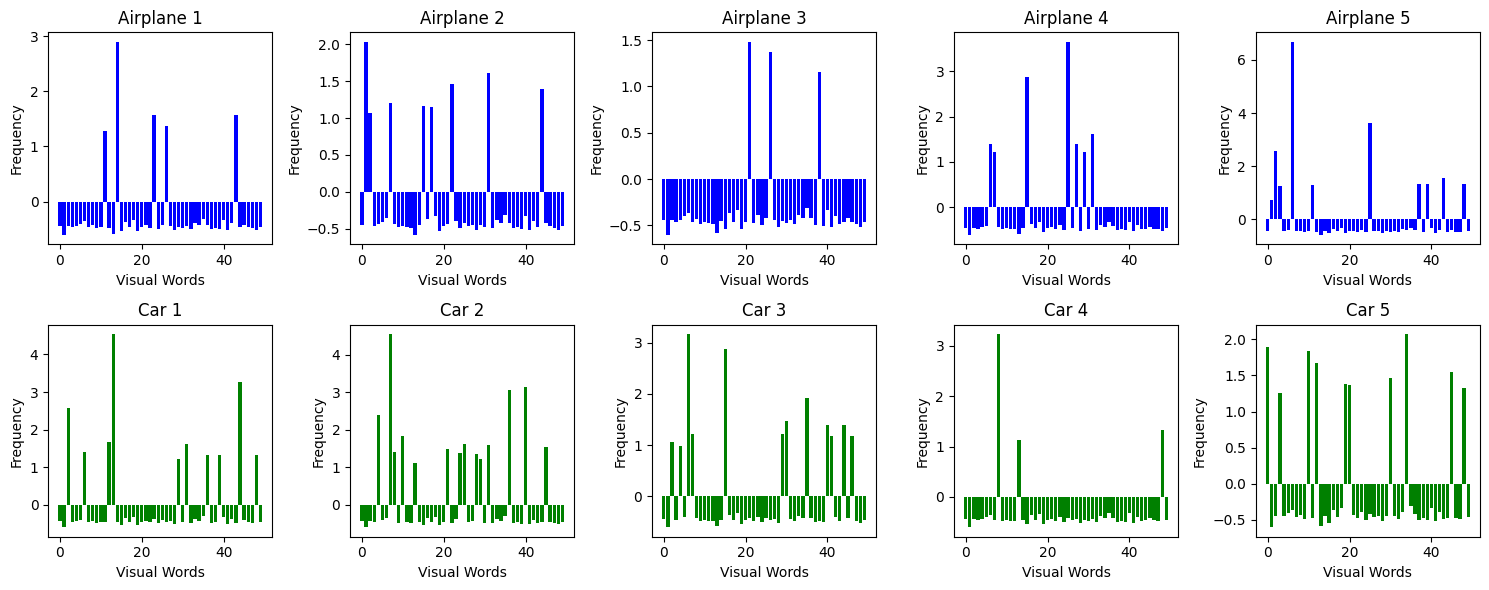

In [ ]:
airplane_indices = random.sample(range(100), 5)
car_indices = random.sample(range(100, 200), 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot 5 histograms for airplanes (class 0)
for i, idx in enumerate(airplane_indices):
    axes[0, i].bar(range(n_clusters), image_histograms[idx], color='blue')
    axes[0, i].set_title(f'Airplane {i+1}')
    axes[0, i].set_xlabel('Visual Words')
    axes[0, i].set_ylabel('Frequency')

# Plot 5 histograms for cars (class 1)
for i, idx in enumerate(car_indices):
    axes[1, i].bar(range(n_clusters), image_histograms[idx], color='green')
    axes[1, i].set_title(f'Car {i+1}')
    axes[1, i].set_xlabel('Visual Words')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Create labels for the selected classes (0 for airplane, 1 for car)
labels = np.array([0]*100 + [1]*100)  # First 100 are airplanes, next 100 are cars

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(image_histograms, labels, test_size=0.3, random_state=42)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
  print(f"Kernel: {kernel}")
  # Train SVM classifier
  svm = SVC(kernel=kernel)
  svm.fit(X_train, y_train)

  # Predict on the test set
  y_pred = svm.predict(X_test)

  # Evaluate the model
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  # Print accuracy
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n\n\n")

Kernel: linear
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.58      0.57        31
           1       0.54      0.52      0.53        29

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.55      0.55      0.55        60

Accuracy: 0.55



Kernel: poly
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.97      0.69        31
           1       0.75      0.10      0.18        29

    accuracy                           0.55        60
   macro avg       0.64      0.54      0.44        60
weighted avg       0.64      0.55      0.44        60

Accuracy: 0.55



Kernel: rbf
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        31
           1       0.67      0.76      0.71        29

    accuracy                         

### Face Recognition

DeepFace [(clicky to paper)](https://research.facebook.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/), one of the most popular models in this genre, is a lightweight [face recognition](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/) and facial attribute analysis ([age](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/), [gender](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/), [emotion](https://sefiks.com/2018/01/01/facial-expression-recognition-with-keras/) and [race](https://sefiks.com/2019/11/11/race-and-ethnicity-prediction-in-keras/)) framework for python.

It currently uses the following SOTA models with `VGG-Face` being the default.
```py
models = [
  "VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", "GhostFaceNet",
]
```

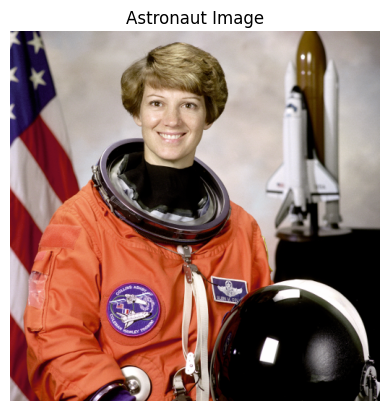

In [ ]:
astronaut_image = data.astronaut()
astronaut_bgr = cv2.cvtColor(astronaut_image, cv2.COLOR_RGB2BGR)

plt.imshow(astronaut_image)
plt.title("Astronaut Image")
plt.axis('off')
plt.show()

In [ ]:
embedding_objs = DeepFace.represent(astronaut_bgr)

24-09-19 14:18:53 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:02<00:00, 281MB/s]


In [ ]:
print(embedding_objs[0].keys())
print(len(embedding_objs[0]["embedding"]))

dict_keys(['embedding', 'facial_area', 'face_confidence'])
4096


In [ ]:
%%capture
analyze_face = DeepFace.analyze(astronaut_bgr)

In [15]:
analyze_face

NameError: name 'analyze_face' is not defined

In [16]:
analyze_face[0]['dominant_emotion']

NameError: name 'analyze_face' is not defined

### Szeliski is a really good resource for today's Colab session. See sections 6.2 and 6.3 for more info.

# Intersection Over Union (IoU)

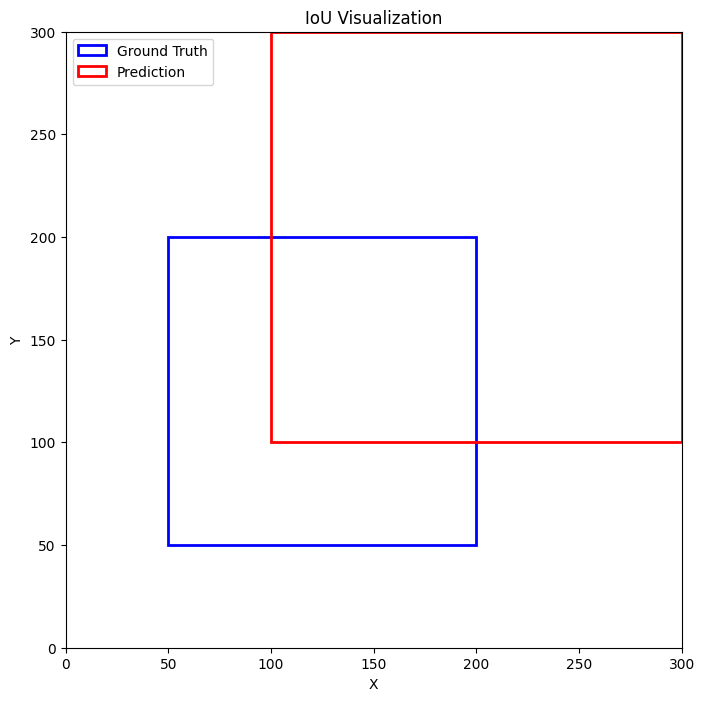

In [17]:
# Define ground truth and predicted bounding boxes
gt_box = [50, 50, 150, 150]  # [x, y, width, height]
pred_box = [100, 100, 200, 200]  # [x, y, width, height]

fig, ax = plt.subplots(1, figsize=(8, 8))

# Plot ground truth box
gt_rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2], gt_box[3],
                            linewidth=2, edgecolor='blue', facecolor='none', label='Ground Truth')
ax.add_patch(gt_rect)

# Plot predicted box
pred_rect = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                              linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
ax.add_patch(pred_rect)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('IoU Visualization')
plt.legend()

# Display the plot
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [18]:
# Calculate the coordinates of the intersection rectangle
x_left = max(gt_box[0], pred_box[0])
y_top = max(gt_box[1], pred_box[1])
x_right = min(gt_box[0] + gt_box[2], pred_box[0] + pred_box[2])
y_bottom = min(gt_box[1] + gt_box[3], pred_box[1] + pred_box[3])

# Calculate the width and height of the intersection rectangle
intersection_width = max(0, x_right - x_left)
intersection_height = max(0, y_bottom - y_top)

# Calculate the area of intersection
intersection_area = intersection_width * intersection_height

# Calculate the area of the ground truth and predicted boxes
gt_area = gt_box[2] * gt_box[3]
pred_area = pred_box[2] * pred_box[3]

# Calculate the area of union
union_area = gt_area + pred_area - intersection_area

# Calculate IoU
iou = intersection_area / union_area

# Print the IoU
print(f'Intersection Area: {intersection_area}')
print(f'Union Area: {union_area}')
print(f'IoU: {iou}')

Intersection Area: 10000
Union Area: 52500
IoU: 0.19047619047619047
